In [1]:
#Importando Bibliotecas
import tensorflow as tf
import tensorflow_datasets as tfds #Dataset API
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Visualização de dados
import os #Manippulação de arquivos
from PIL import Image #Manipulação de imagens

import warnings
warnings.filterwarnings('ignore') #ignora avisos

# Estrutura de Diretórios

Iremos salvar as imagens em pastas para replicar as condições do mundo real, como se fosse um dataset fora dos exemplos do tensorflow

Para usar o ImageDataGenerator, as imagens precisam ser organizadas em uma organização de pastas específica (mostrada abaixo).

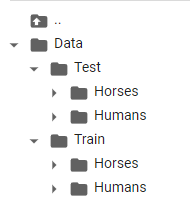

In [2]:
#Fazendo pastas para guardar as imagens do dataset
os.makedirs('Data', exist_ok=True)
os.makedirs('Data/Train/Horses', exist_ok=True)
os.makedirs('Data/Train/Humans', exist_ok=True)
os.makedirs('Data/Test/Horses', exist_ok=True)
os.makedirs('Data/Test/Humans', exist_ok=True)

base_path = os.getcwd()
horse_counter = 0
human_counter = 0

#O código abaixo salva as imagens do datase nas pastas criadas acima
#Fazer isso não é necessário para usar datasets do próprio Tensorflow, porém
#será necessário caso usemos outros conjuntos de dados que não os tensorflow

for i, dataset in enumerate(tfds.load('horses_or_humans', split=['train', 'test'])):
    if i==0: #Conjunto de treino
        set_path = os.path.join(base_path, 'Data/Train')
    else: #Conjunto de teste
        set_path = os.path.join(base_path, 'Data/Test')
        
    for row in list(dataset):
        im = Image.fromarray(row['image'].numpy())
        if row['label'] == 0: #0 é cavalo e 1 é humano
            class_path = os.path.join(set_path, 'Horses')
            file_path = os.path.join(class_path, "horse_{}.jpeg".format(horse_counter))
            horse_counter += 1
        elif row['label'] == 1: #0 é cavalo e 1 é humano
            class_path = os.path.join(set_path, 'Humans')
            file_path = os.path.join(class_path, "human_{}.jpeg".format(horse_counter))
            human_counter += 1
        im.save(file_path) #salva a imagem na pasta certa


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteI2EL1P/horses_or_humans-train.tfrecord


  0%|          | 0/1027 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteI2EL1P/horses_or_humans-test.tfrecord


  0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [3]:
print('Número de imagens de cavalos no conjunto de treinamento:', len(os.listdir('Data/Train/Horses')))
print('Número de imagens de humanos no conjunto de treinamento::', len(os.listdir('Data/Train/Humans')))
print('\n')
print('Número de imagens de cavalos no conjunto de testes:', len(os.listdir('Data/Test/Horses')))
print('Número de imagens de humanos no conjunto de testes:', len(os.listdir('Data/Test/Humans')))

Número de imagens de cavalos no conjunto de treinamento: 500
Número de imagens de humanos no conjunto de treinamento:: 259


Número de imagens de cavalos no conjunto de testes: 128
Número de imagens de humanos no conjunto de testes: 66


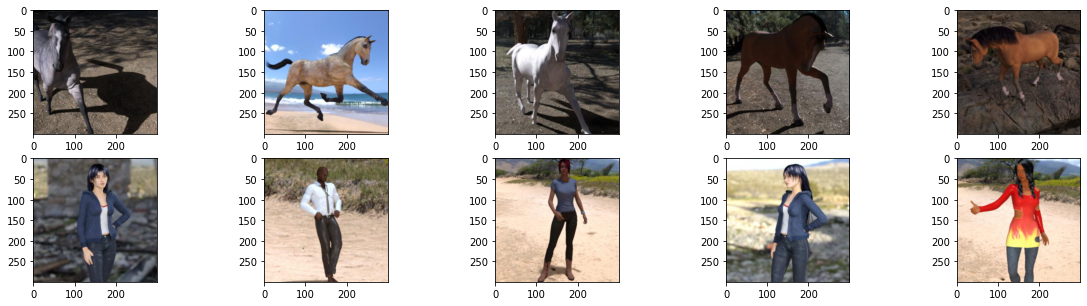

In [4]:
#Printando Imagens de exemplo
horse_imgs = []
human_imgs = []

for i in range(5):
    horse_im = Image.open(os.path.join('Data/Train/Horses', os.listdir('Data/Train/Horses')[i]))
    human_im = Image.open(os.path.join('Data/Train/Humans', os.listdir('Data/Train/Humans')[i]))
    horse_imgs.append(horse_im)
    human_imgs.append(human_im)
    

plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        if i == 0:
            axs[i, j].imshow(horse_imgs[j])
        else:
            axs[i, j].imshow(human_imgs[j])
plt.show()

# Tratamento de dados com `ImageDataGenerator` 
carrega e realiza ajustes nas imagens.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#documentação -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
print('Conjunto de treino:')
train_gen = ImageDataGenerator(
    rescale=(1./255), #Redimensiona os pixels (originalmente 0-256) para 0-1
    rotation_range=0.4, #Gira a imagem 40 graus
    shear_range=0.2, #corta a imagem até 20 graus
    width_shift_range=0.2, #muda a largura em 20 %
    height_shift_range=0.2, #muda a altura em 20 %
    horizontal_flip=True, #vira a imagem no eixo horizontal
    fill_mode='nearest' #preenche os pixels com o pixel mais próximo
    )

train_generator = train_gen.flow_from_directory(
    'Data/Train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

#Fazendo a mesma coisa para o conjunto de teste, mas sem nenhum aumento
print('Conjunto de teste:')
test_gen = ImageDataGenerator(rescale=(1./255))

test_generator = test_gen.flow_from_directory(
    'Data/Test',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Conjunto de treino:
Found 759 images belonging to 2 classes.
Conjunto de teste:
Found 194 images belonging to 2 classes.


**Convolution Layer -> Pooling Layer... -> Flatten -> Dense**

In [6]:
#Criando modelo 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout


model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [7]:
#Treinando o modelo

from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20
)

Epoch 1/20
24/24 [==============================] - 19s 747ms/step - loss: 0.7532 - accuracy: 0.6206
Epoch 2/20
24/24 [==============================] - 18s 753ms/step - loss: 0.4922 - accuracy: 0.7905
Epoch 3/20
24/24 [==============================] - 18s 743ms/step - loss: 0.3711 - accuracy: 0.8551
Epoch 4/20
24/24 [==============================] - 19s 772ms/step - loss: 0.3518 - accuracy: 0.8524
Epoch 5/20
24/24 [==============================] - 18s 753ms/step - loss: 0.2813 - accuracy: 0.8814
Epoch 6/20
24/24 [==============================] - 18s 742ms/step - loss: 0.1972 - accuracy: 0.9236
Epoch 7/20
24/24 [==============================] - 18s 745ms/step - loss: 0.1873 - accuracy: 0.9341
Epoch 8/20
24/24 [==============================] - 18s 743ms/step - loss: 0.1964 - accuracy: 0.9275
Epoch 9/20
24/24 [==============================] - 18s 749ms/step - loss: 0.1448 - accuracy: 0.9499
Epoch 10/20
24/24 [==============================] - 18s 743ms/step - loss: 0.1282 - accura

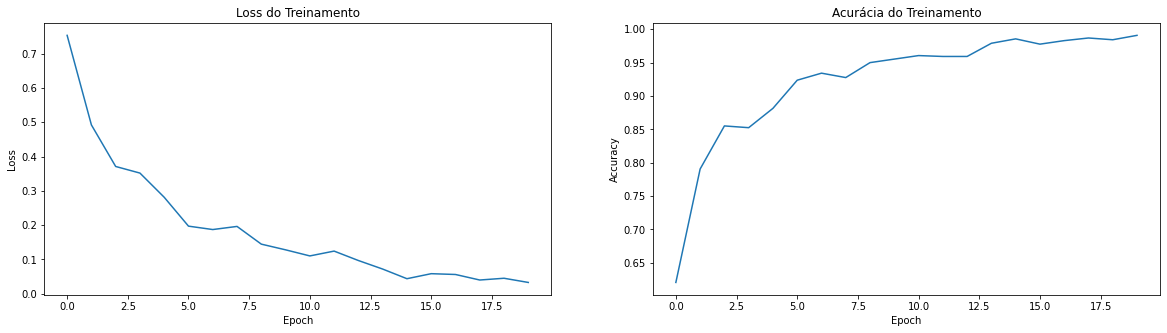

In [8]:
#Plots model training history

fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss do Treinamento')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Acurácia do Treinamento')

plt.show()

In [9]:
#Evaluate Custom CNN on Test Data
#We will now see how well our model performs on test data. 
#It is likely that the model is overfitting the training data.
test_acc = model.evaluate(test_generator, verbose=0)[1]
print('Acurácia do modelo nos conjuntos de teste:', round(test_acc,3))

Acurácia do modelo nos conjuntos de teste: 0.691


In [10]:
#método para salvar nosso modelo para usar fora do jupyter

#!pip install pyyaml h5py  #Necessário para salvar modelos em formato .h5

model.save('CNN_cavalos_ou_humanos.h5') 

#Agora podemos testar nosso modelo com imagens de verdade!

rode o código abaixo para testar o modelo com upload de imagens reais.

Saving Valton-Pessoa-450x675.jpg to Valton-Pessoa-450x675.jpg


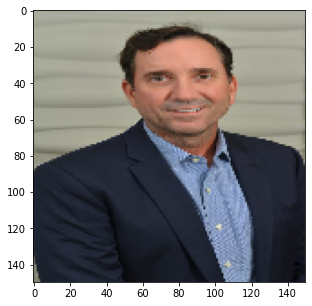

Valton-Pessoa-450x675.jpg É um humano


In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn 
  img = image.load_img(path, target_size=(150, 150))
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  #print(classes[0])
  if classes[0]>0.5:
    print(fn+' É um humano')
  else:
    print(fn+' É um cavalo')

#Predições com imagens reais

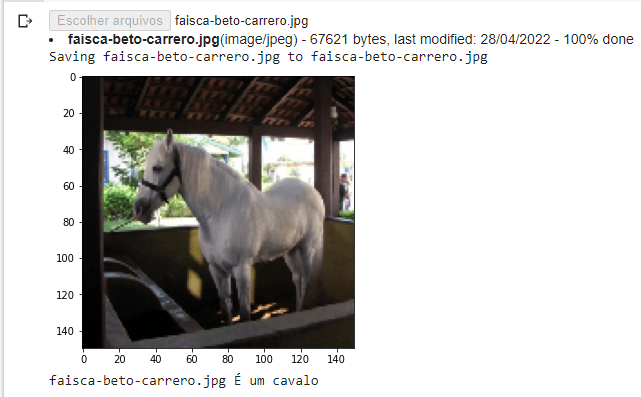

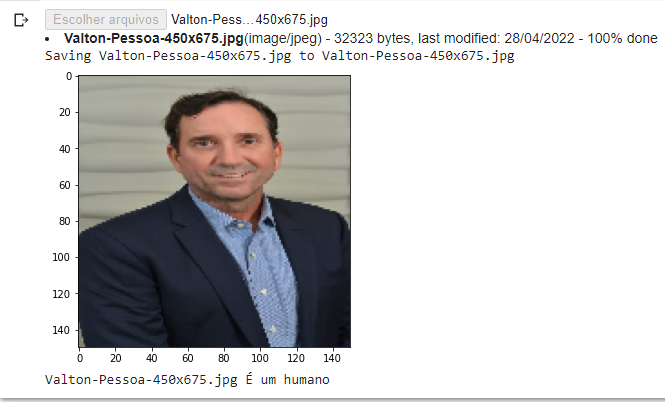

# Referências

### materiais consultados e que serviram de norte para o projeto:

**Template de Deploy para modelos CNN**:
https://github.com/imfing/keras-flask-deploy-webapp

**TensorFlow Image Classification Guide**: https://www.kaggle.com/code/calebreigada/tensorflow-image-classification-guide

**Convolutional Neural Networks (CNNs) explained**:
https://www.youtube.com/watch?v=YRhxdVk_sIs

**Horse or Human Image Classification**:
https://medium.datadriveninvestor.com/horse-or-human-image-classification-c98b9dc94f6f

**Repositório repleto de referencias para colocar em produção um modelo de machine leaning**:
https://github.com/ahkarami/Deep-Learning-in-Production